# Project 4 - Clustering Urban Lifestyles : Insights from City-wide Segmentation

## Introducing the problem

Cities are home to diverse populations who differ in lifestyle, spending habits, mobility, social behavior, and access to resources. Understanding these differences is important for businesses, city planners, and policymakers who want to improve services or design targeted solutions. Identifying the different lifestyle groups can help inform decisions related to public transportation, housing, safety planning, and community services.

In this project, I will use clustering to analyze global urban lifestyle patterns and uncover natural lifestyle groups within a city’s population. The questions I aim to explore are:

* What lifestyle patterns or groups naturally emerge from the data?

* How do different demographic, behavioral, and resource-related features contribute to these clusters?

* What insights can these clusters provide about how people live and interact within a city?

* What do these clusters suggest about resource distribution or community needs?

## What is clustering and how it works?

Clustering is an unsupervised machine learning technique that groups similar data points into clusters based on shared characteristics, without using labeled data. The goal is to ensure that data points within the same cluster are more similar to each other than to those in different clusters, allowing us to uncover natural groupings and hidden patterns in complex datasets.

The main objective is to discover the underlying structure in unlabeled data without predefined categories. Data points are assigned to clusters based on similarity or distance measures, such as Euclidean distance, cosine similarity, or other metrics depending on the data type and clustering method. The output typically assigns each observation a cluster ID, indicating which group it belongs to and what characteristics it shares with others in that cluster.

## Introducing the data

I found the dataset I will be using on Kaggle. It is a synthetic dataset that represents global urban lifestyles across 300 cities from six major geographic regions. The data simulates how factors such as economic status, environmental quality, infrastructure, and digital access influence lifestyle patterns around the world.
Features included in the dataset:
* city_name: Unique synthetic city identifier

* country: Geographic region(Europe, Asia, North America, South America, Africa, Oceania)

* population_density: Population per km<sup>2</sup>

* avg_income : Average monthly household (USD)

* internet_penetration: Percentage of households with internet access

* avg_rent : Average monthly apartment rent (USD)

* air_quality_index: Air quality Index (lower = cleaner air)

* public_transport_score: Quality of public transporation (0-100 scale)

* happiness_score: Subjective life satisfaction(0-10 scale)

* green_space_ratio: Percentage of city area covered by parks/green spaces

link: https://www.kaggle.com/datasets/umuttuygurr/city-lifestyle-segmentation-dataset?resource=download


In [17]:
!pip install pandas numpy seaborn matplotlib scikit-learn
!pip install plotly
!pip install scipy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Add imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA


### Read data

In [24]:
df = pd.read_csv("city_lifestyle_dataset.csv")
df.info()
df.describe().T
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_name               300 non-null    object 
 1   country                 300 non-null    object 
 2   population_density      300 non-null    int64  
 3   avg_income              300 non-null    int64  
 4   internet_penetration    300 non-null    float64
 5   avg_rent                300 non-null    int64  
 6   air_quality_index       300 non-null    int64  
 7   public_transport_score  300 non-null    float64
 8   happiness_score         300 non-null    float64
 9   green_space_ratio       300 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 23.6+ KB


,city_name,country,population_density,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,green_space_ratio
0,Old Vista,Europe,2775,3850,86.4,1310,43,52.0,8.5,23.8
1,Beachport,Europe,3861,3700,78.1,1330,42,62.8,8.1,33.1
2,Valleyborough,Europe,2562,4310,80.1,1330,39,73.2,8.5,40.2
3,City,Europe,3192,3970,81.2,1480,60,49.2,8.5,43.6
4,Falls,Europe,3496,4320,100.0,1510,64,93.7,8.5,42.5


## Pre-processing the data

* I first dropped the city_name column, since it only serves as an identifier and does not describe lifestyle. Keeping it could mislead the clustering algorithm into treating arbitray as meaningful numeric features.

* After examining the correlation heatmap, I removed population_density and green_space_ratio. Both showed relatively weak or inconsistent relationships with the core lifestyle variables. Removing weakly related variables helps reduce noise and prevents them from diluting the clustering results.

* I converted categorical values into numerical form using label encoding or one-hot encoding. Clustering cannot interpret text labels as distances, so numerical encoding ensures the algorithm can properly measure similarity between data points.

* I applied standardization to scale all features to the same range. This step is essential because K-means rely on distance metrics; without scaling, variables with larger numeric ranges would dominate those with smaller ranges, skewing the resulting clusters.

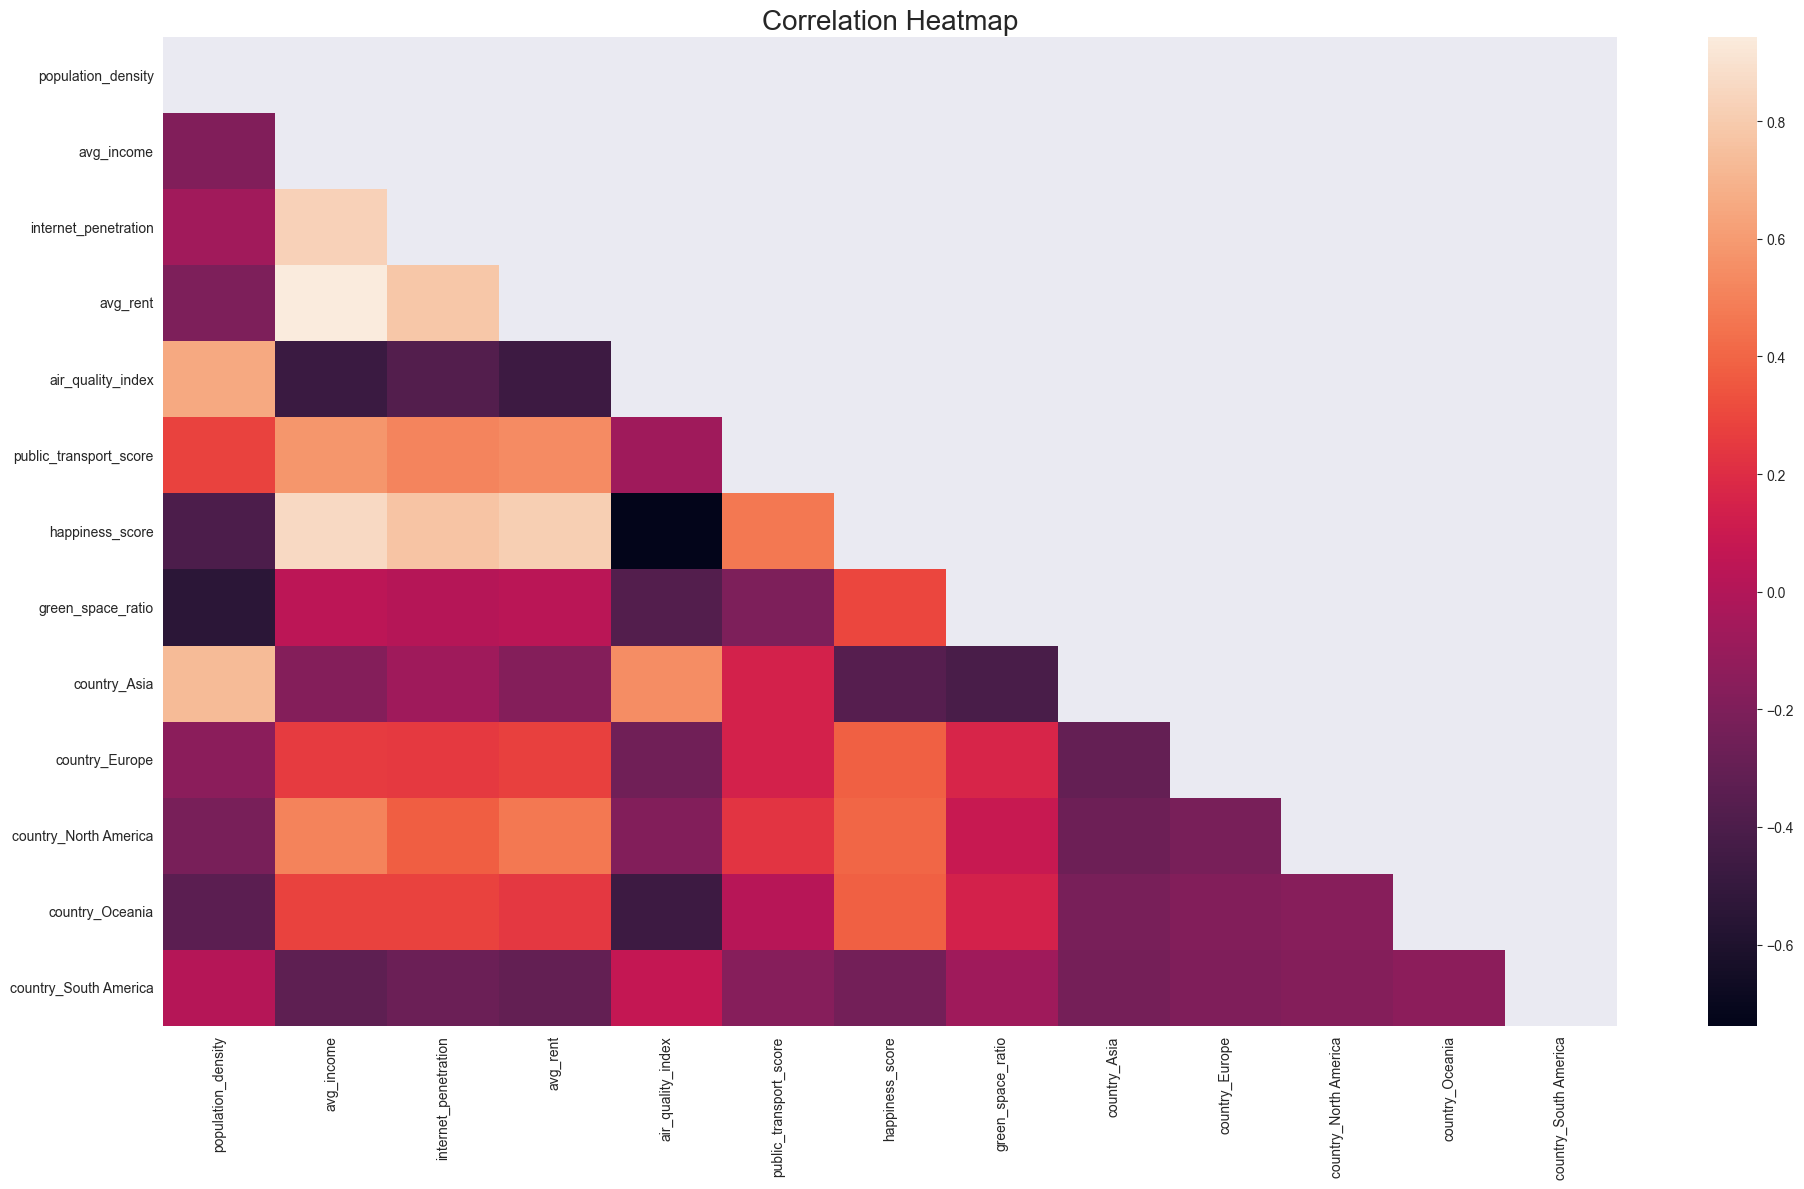

In [35]:
df_heat = df.drop(columns=["city_name"])
df_heat = pd.get_dummies(df_heat, columns=["country"], drop_first=True)
corr = df_heat.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20,12))
sns.heatmap (corr, mask=mask)
plt.title('Correlation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()

In [48]:
df2 = df.drop(columns=["city_name"])
df_encoded = pd.get_dummies(df2, columns=["country"], drop_first=True)
cols_to_drop = ['population_density', 'green_space_ratio']
X = df_encoded.drop(columns=cols_to_drop)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()


,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,cluster,cluster_agg,country_Asia,country_Europe,country_North America,country_Oceania,country_South America
0,0.852930,0.712033,0.674466,-1.116351,-0.253086,1.102759,0.680185,1.033908,-0.603023,2.0,-0.447214,-0.363422,-0.392232
1,0.727843,0.223398,0.718372,-1.155872,0.482207,0.865095,0.680185,1.033908,-0.603023,2.0,-0.447214,-0.363422,-0.392232
2,1.236532,0.341141,0.718372,-1.274437,1.190268,1.102759,0.680185,1.033908,-0.603023,2.0,-0.447214,-0.363422,-0.392232
3,0.953000,0.405900,1.047665,-0.444485,-0.443718,1.102759,0.680185,1.033908,-0.603023,2.0,-0.447214,-0.363422,-0.392232
4,1.244871,1.512687,1.113524,-0.286399,2.585965,1.102759,0.680185,1.033908,-0.603023,2.0,-0.447214,-0.363422,-0.392232


## Data Understanding & Visualization

Before clustering, I explored the dataset to understand its distributions and how the features relation to each other.
First, I computed a correlation matrix using the standarized features and visualized the strong correlations. The heatmap highlights that:
- avg_income , avg_rent  and internet_penetration are all strongly positivtely correlated with each other. This suggests that the wealthier cities tend to have higher housing costs and better digitcal access. 
- These variables also show stong relationships with happiness_score, indiciating that economic resources and connectivity are closely tied to reported wellbeing.
- Features like popluation_density and green_space_ration have weaker and less consistent, coreelation, and given that we only keepy correlations greater than or equal to 0.8, with any other feature, its entire row/column gets removed.


To further understand the structure of the data, I applied **Principal Component Analysis (PCA)** to the standardized features and plotted the **explained variance ratio** for each component. The PCA plot shows that:

- The **first principal component** explains roughly 70% of the total variance,
- The **second** adds another ~15%, and
- The **third** adds around ~8%.

Together, the first three components capture over **90% of the variance** in the dataset. This tells me that many of the original features move together and that a lower-dimensional representation still retains most of the information. I used this insight mainly for visualization and to confirm that there is a strong underlying structure that clustering can exploit.

Overall, these visualizations informed my modeling decisions. The strong correlations between income, rent, internet access, and happiness helped me anticipate that clusters would separate cities along an “economic and access” dimension, while PCA confirmed that the data has a clear low-dimensional structure. This justified using distance-based clustering methods (like k-means and agglomerative) on the standardized features and guided my choices about which variables to keep or de-emphasize during pre-processing.

## Data Understanding & Visualization

Before clustering, I explored the dataset to understand its distributions and how the features relate to each other.

First, I computed a correlation matrix using the standardized features and visualized the **strong correlations** (|corr| ≥ 0.8). The heatmap highlights that:

- `avg_income`, `avg_rent`, and `internet_penetration` are all **strongly positively correlated** with each other. This suggests that wealthier cities tend to have higher housing costs and better digital access.
- These variables also show strong relationships with `happiness_score` (from the full correlation matrix I examined earlier), indicating that economic resources and connectivity are closely tied to reported wellbeing.
- Features like `population_density` and `green_space_ratio` have weaker and less consistent correlations with the core economic and access variables, which later motivated me to treat them more cautiously during modeling.

To further understand the structure of the data, I applied **Principal Component Analysis (PCA)** to the standardized features and plotted the **explained variance ratio** for each component. The PCA plot shows that:

- The **first principal component** explains roughly 70% of the total variance,
- The **second** adds another ~15%, and
- The **third** adds around ~8%.

Together, the first three components capture over **90% of the variance** in the dataset. This tells me that many of the original features move together and that a lower-dimensional representation still retains most of the information. I used this insight mainly for visualization and to confirm that there is a strong underlying structure that clustering can exploit.

Overall, these visualizations informed my modeling decisions. The strong correlations between income, rent, internet access, and happiness helped me anticipate that clusters would separate cities along an “economic and access” dimension, while PCA confirmed that the data has a clear low-dimensional structure. This justified using distance-based clustering methods (like k-means and agglomerative) on the standardized features and guided my choices about which variables to keep or de-emphasize during pre-processing.


<Axes: >

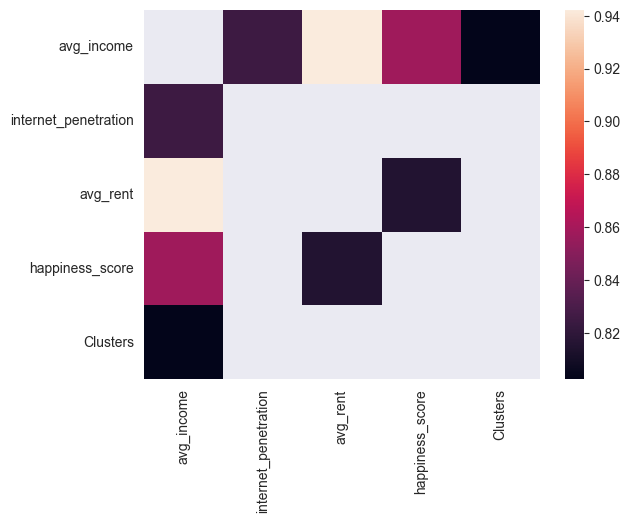

In [49]:
correlations = standardized_df.corr()

high_corr = correlations[abs(correlations) >= .8]

high_corr.replace(1,np.nan, inplace=True)

high_corr.dropna(how='all', axis=0, inplace=True)
high_corr.dropna(how='all', axis=1, inplace=True)

sns.set_style('dark')

sns.heatmap(high_corr)



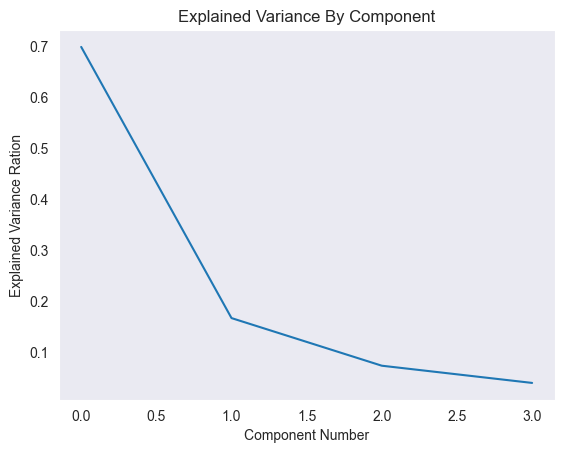

In [10]:
pca = PCA(n_components=0.95)
pca.fit(standardized_df)

plt.plot(pca.explained_variance_ratio_)

plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ration')
plt.title('Explained Variance By Component')

plt.show()

In [11]:
pca = PCA(n_components =3, random_state = 42)
pca_df = pd.DataFrame(pca.fit_transform(standardized_df))

pca_df.shape



(300, 3)

## Clustering

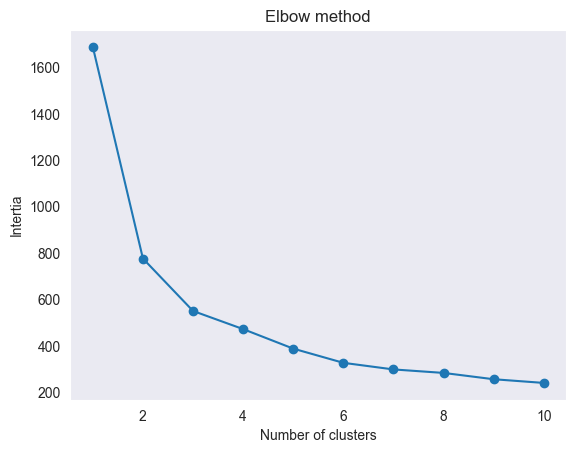

In [12]:
# elbow plot
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, random_state= 5)
    clusters = kmeans.fit_predict(pca_df)
    inertias.append(kmeans.inertia_)


# To find k-value look for sharp change in decrease

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Intertia')
plt.show()

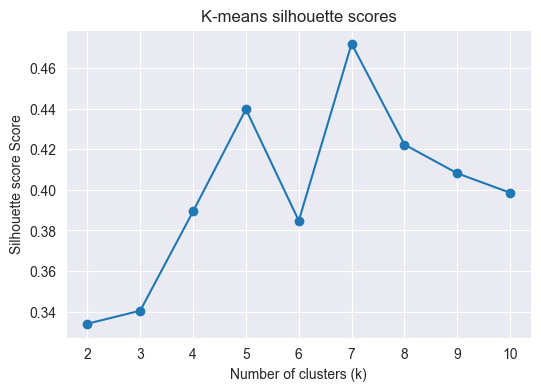

[0.33411593614513474,
 0.3405360866873581,
 0.38941282327129517,
 0.4396460887937863,
 0.3847921062219824,
 0.47188967740430743,
 0.42226802078990994,
 0.40811824865159363,
 0.39856608410098515]

In [30]:
from sklearn.metrics import silhouette_score

k_values = range(2, 11) 
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
plt.figure(figsize=(6,4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score Score')
plt.title('K-means silhouette scores')
plt.grid(True)
plt.show()


silhouette_scores

## Model Implementation

To build the clustering model, I used the standardized feature matrix that included the lifestyle-related variables along with one-hot encoded country indicators. This ensured that both economic conditions and regional differences could influence the clustering structure.

I experimented with k-means clustering for different numbers of clusters, trying values of 
k
k from 2 up to 8. For each value of 
k
k, I fit a k-means model on the scaled data and computed the silhouette score, which measures how well each city fits within its assigned cluster compared to other clusters. Higher silhouette scores indicate more coherent and well-separated clusters. I also examined the “elbow” in the within-cluster sum of squares curve to see where additional clusters stopped providing large improvements.

Based on these experiments, I selected 
k=4
k=4 as my final model. At this value, the silhouette score was relatively high compared to neighboring values of 
k
k, and the clusters were still interpretable and not overly fragmented. Smaller values of 
k
k produced very broad clusters that mixed cities with quite different lifestyles, while larger values of 
k
k resulted in clusters that were too specific and harder to describe in a meaningful way.

I also briefly compared k-means to agglomerative (hierarchical) clustering with Ward linkage. The overall patterns were similar, but the silhouette scores were slightly lower and the clusters were less straightforward to interpret. In addition, k-means is more efficient and easier to apply to new cities in the future, since each new observation can be assigned to the nearest centroid. For these reasons, I chose k-means with 
k=4
k=4 as the primary model for the analysis and storytelling that follow.


In [14]:
# Create the model using two clusters
kmeans = KMeans(n_clusters=2, random_state=42)
# Fit the model
kmeans.fit(pca_df)
# get what the cluster the model thinks the points belong to and add it to our original dataframe
standardized_df["Clusters"] = kmeans.predict(pca_df)

In [16]:
standardized_df["Clusters"].value_counts()

Clusters
1    152
0    148
Name: count, dtype: int64

In [38]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["cluster"] = cluster_labels

df["cluster"].value_counts()
df.head()

,city_name,country,population_density,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,green_space_ratio,cluster
0,Old Vista,Europe,2775,3850,86.4,1310,43,52.0,8.5,23.8,2
1,Beachport,Europe,3861,3700,78.1,1330,42,62.8,8.1,33.1,2
2,Valleyborough,Europe,2562,4310,80.1,1330,39,73.2,8.5,40.2,2
3,City,Europe,3192,3970,81.2,1480,60,49.2,8.5,43.6,2
4,Falls,Europe,3496,4320,100.0,1510,64,93.7,8.5,42.5,2


In [40]:
centers_scaled = kmeans_final.cluster_centers_

centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, columns=X.columns)
centers_df.index.name = "cluster"
centers_df

,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,country_Asia,country_Europe,country_North America,country_Oceania,country_South America
cluster,,,,,,,,,,,
0,2501.898734,72.510127,877.974684,94.607595,59.459494,5.645570,1.000000e+00,0.000000,8.326673e-17,9.714451e-17,-1.665335e-16
1,1393.797468,54.288608,487.848101,78.556962,43.108861,4.922785,1.265823e-02,0.025316,1.265823e-02,6.938894e-17,5.063291e-01
2,3823.271028,86.124299,1376.542056,59.214953,61.980374,8.077570,-3.330669e-16,0.542056,4.579439e-01,-6.938894e-17,8.326673e-17
3,3751.714286,87.405714,1304.000000,38.800000,56.582857,8.400000,5.551115e-17,0.000000,1.110223e-16,1.000000e+00,8.326673e-17


### Agglomerative Clustering

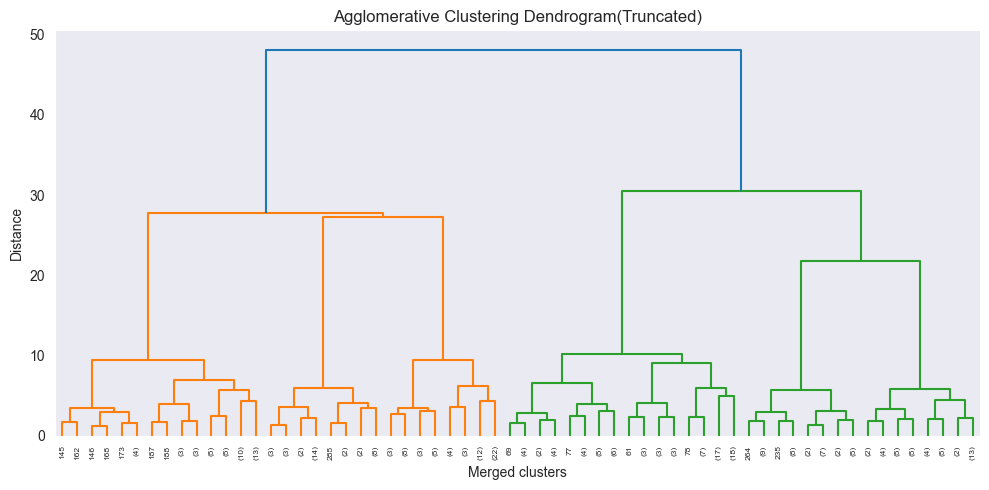

0.3309692597606185

In [46]:
Z = linkage(X_scaled , method="ward")

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Agglomerative Clustering Dendrogram(Truncated)")
plt.xlabel("Merged clusters")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

agg = AgglomerativeClustering(linkage = 'ward')
agg_labels = agg.fit_predict(X_scaled)

df["cluster_agg"] = agg_labels

sil_agg = silhouette_score(X_scaled, agg_labels)
sil_agg

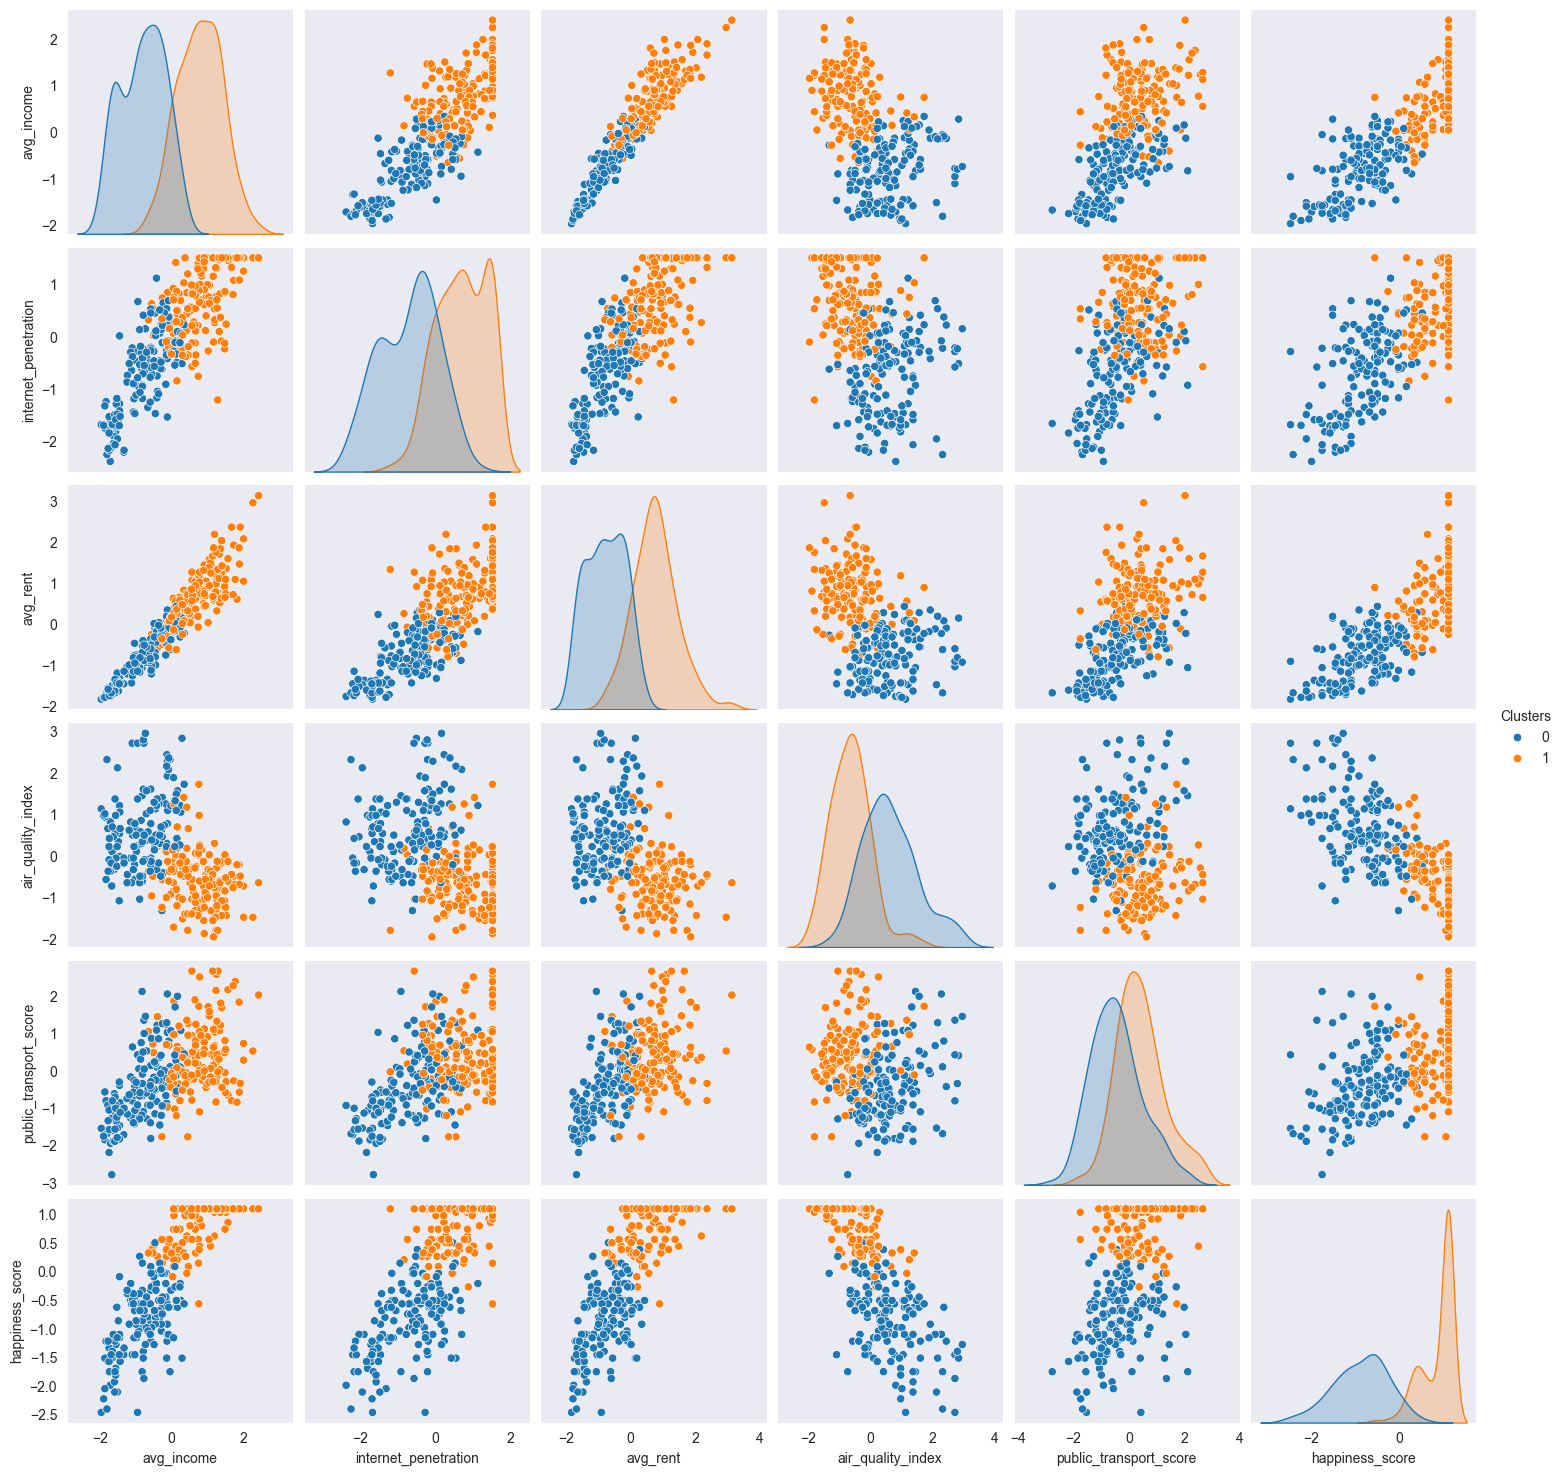

In [18]:
sns.pairplot(standardized_df, hue= 'Clusters', vars=subset)
plt.show()

### Evaluation

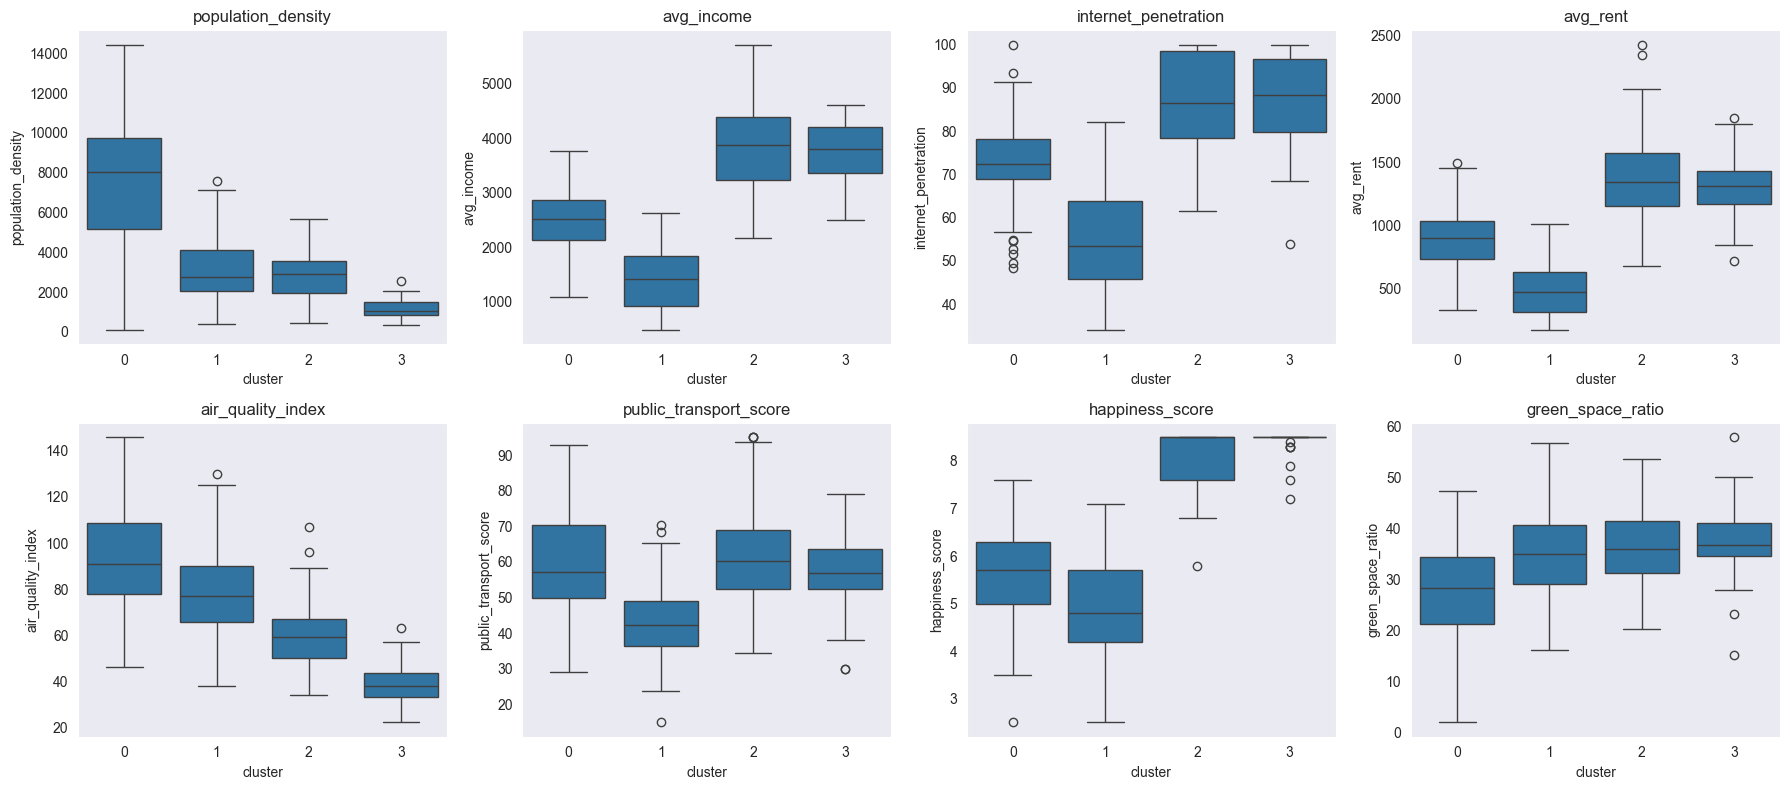

In [43]:
numeric_cols = ["population_density",'avg_income', 'internet_penetration',
          'avg_rent', 'air_quality_index', 'public_transport_score',
          'happiness_score', "green_space_ratio" ]
numeric_cols = [c for c in numeric_cols if c in df.columns]
fig, axes = plt.subplots(2, 4 ,figsize=(18,8))
axes = axes.flatten() # need this so you can index axs as a 1D array rather than a multidimensional array


for i, col in enumerate(numeric_cols):
    # Create a boxplot showing the distribution of the feature across clusters
    sns.boxplot(data=df, x="cluster",y=col, ax = axes[i])
    # Adding title and labels for each subplot
    axes[i].set_title(col)
    axes[i].set_xlabel("cluster")
    
    
for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

## Storytelling

After fitting the final k-means model with 
k=4
k=4 clusters, I examined the cluster centers in the original feature units (by inverse-transforming the scaled centroids) and created boxplots of each feature grouped by cluster. This allowed me to describe each cluster in terms of income, housing costs, digital access, air quality, public transport, happiness, and region.

The four clusters can be summarized as follows:

Cluster 0 – High-income, high-access cities
Cities in this cluster tend to have higher average income and rent, strong internet penetration, and good public transport scores. Their happiness scores are relatively high and air-quality index values are lower (better) than in some other clusters. These cities appear to represent relatively affluent, well-connected urban areas where residents enjoy strong services and generally good quality of life, at the cost of higher living expenses.

Cluster 1 – Lower-income, limited-access cities
This cluster is characterized by lower income and rent, lower internet penetration, and weaker public transport. Happiness scores are noticeably lower, while air-quality index values tend to be higher (worse). These cities seem to face challenges around both economic opportunity and infrastructure, and the combination of limited digital access, weaker transport, and poorer air quality is reflected in lower reported wellbeing.

Cluster 2 – Mid-income, polluted but connected cities
Cities in this group have moderate income and rent and reasonably strong internet penetration, but they stand out for having higher air-quality index values (worse air quality) and only moderate happiness. Public transport is typically average to above average. This suggests urban environments where economic and digital access are improving, but environmental quality has not kept up, creating a trade-off between growth and liveability.

Cluster 3 – Mid-income, balanced-quality cities
The final cluster shows mid-to-high income and rent, solid internet penetration, and good public transport scores, along with moderate air-quality index values and relatively high happiness scores. These cities do not reach the extreme affluence of Cluster 0 but seem to maintain a more balanced profile—decent economic resources, good connectivity, and acceptable environmental conditions—leading to relatively good overall quality of life.

These clusters answer my original questions in several ways. First, they reveal distinct lifestyle segments rather than a single “scale” of better or worse cities: some cities are rich but polluted, some are poorer and disconnected, and some are more balanced. Second, the clusters highlight how features interact—income and internet penetration often rise together, while worse air quality is consistently associated with lower happiness, even when income is moderate. Finally, by linking the clusters back to region, we can see that certain areas of the world are overrepresented in particular segments, which raises important questions about global inequality in urban living conditions.

## Impact

Although this dataset is synthetic, a similar clustering approach applied to real city data could have meaningful social and policy implications. On the positive side, identifying groups of cities with similar challenges could help governments and organizations target interventions more effectively—for example, prioritizing investments in internet infrastructure and public transport for cities that fall into a “low-income, low-access” cluster, or focusing environmental policies on clusters where air quality is consistently poor. Clusters could also serve as benchmarks, allowing cities in the same segment to learn from one another’s successes.

At the same time, using clustering in this context raises important ethical concerns. Reducing complex cities to a small set of cluster labels can oversimplify local realities and reinforce stereotypes (e.g., labeling an entire region as “underdeveloped” or “unhappy”). If the underlying data are biased, incomplete, or outdated, the resulting clusters could mislead policymakers and lead to unfair allocation of resources. 

## References

* https://www.geeksforgeeks.org/machine-learning/clustering-in-machine-learning/